In [1]:
import torch
import numpy as np
import pandas as pd

import time

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, LogLocator

#from google.colab import drive

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

from scipy.stats import pearsonr, spearmanr, kendalltau

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import log_loss
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_auc_score

#import lightgbm as lgb
from lightgbm import LGBMClassifier
from lightgbm import plot_importance

import itertools

# Shuo Chen's blade-chest model: модель сабля-рука
Papers

* "Modeling Intransitivity in Matchup and Comparison Data", Shuo Chen and Thorsten Joachims, <br> https://www.cs.cornell.edu/~shuochen/pubs/wsdm16_chen.pdf <br>
* "Predicting Matchups and Preferences in Context", Shuo Chen and Thorsten Joachims, <br> http://csinpi.github.io/pubs/kdd16_chen.pdf

Original code
* https://github.com/csinpi/blade_chest
* https://github.com/csinpi/matchup

#### A metaphorical illustration of the blade-chest model for intransitivity

Player a and player b are in a sword duel. Player a's blade is closer to player b's chest than vice versa, as shown by the two blue dashed lines. This illustrates how player a has a better chance of winning than player b. 

* https://www.researchgate.net/figure/A-metaphorical-illustration-of-the-blade-chest-model-for-intransitivity-Player-a-and_fig1_310825028

<img src="https://www.researchgate.net/profile/Thorsten-Joachims/publication/310825028/figure/fig1/AS:631996141297666@1527691030297/A-metaphorical-illustration-of-the-blade-chest-model-for-intransitivity-Player-a-and.png" alt="Drawing" style="width: 400px;" >


<img src="https://www.researchgate.net/profile/Thorsten-Joachims/publication/310825028/figure/fig4/AS:631996141277186@1527691030147/Pipeline-of-CONCAT-model.png" alt="Drawing" style="width: 600px;" >

## "Modeling Intransitivity in Matchup and Comparison Data"

"Modeling Intransitivity in Matchup and Comparison Data", Shuo Chen and Thorsten Joachims, <br> https://www.cs.cornell.edu/~shuochen/pubs/wsdm16_chen.pdf 

### 4. EXPERIMENTS
#### 4.1 Synthetic datasets

To demonstrate that our proposed model can capture intransitivity on synthetic datasets, we begin by looking at the classic rockpaper-scissors game. The training dataset is generated as follows:
there are three players, namely rock, paper and scissors. 
We generate 3, 000 games among them, with rock beating scissors 1,000
times, scissors beating paper 1,000 times, and paper beating rock
1,000 times. We trained our blade-chest-dist model without the
bias term, and we set the dimensionality of the vectors to be d = 2.
We then visualize the learned model in the left panel of Figure 2.
Each player is represented by an arrow, with the head being its
blade vector, and the tail being its chest vector. The interlocking
pattern in the visualization is evidence that our model captures the
intransitive rule between the rock, paper and scissors.

There is also an interesting extension of the original rock-paperscissors game in popular culture called 
rock-paper-scissors-lizard-Spock. In addition to the three-way intransitivity between rock,
paper and scissors, new rules for the other two players are added,
and a graphical demonstration of the rules can be found here. 
We generated 1, 000 matches for each matchup, and then do the training and visualization analogous to the classic rock-paper-scissors game. The results are shown in the right panel of Figure 2. Here
we observe the similar interlocking pattern, with each of the 10
matchups correctly demonstrated.

In [2]:
def generate_dataset(units = ['rock', 'paper', 'scissors'], 
                     match = {   ('rock', 'paper')     : 0,
                                  ('rock', 'scissors')  : 1,
                             #     ('rock', 'rock')      : 0.5,
                                 
                                  ('paper', 'scissors') : 0,
                                  ('paper', 'rock', )   : 1,
                             #     ('paper', 'paper')    : 0.5,
                                 
                                  ('scissors', 'rock', )   : 0,
                                  ('scissors', 'paper')    : 1,
                             #     ('scissors', 'scissors') : 0.5
                                },
                     n = 1000, 
                     random_seed = 1543
                    ):
    
    n_units = len(units)
    arr = []

    j = 0
    for i_1, unit_1 in enumerate(units):
        for i_2, unit_2 in enumerate(units):
            
            if unit_1 == unit_2:                   # Исключаем ничьи
                continue
            
            for i in range (n):
                arr.extend( [[ i_1, i_2, match[(unit_1, unit_2)] ]] ) 
                j += 1
          
    np.random.seed(random_seed)
    np.random.shuffle(arr)
       
    return np.array(arr)

In [3]:
def get_team_encoding(X, columns, prefix):
    result = 0
    for col in columns:
        result += pd.get_dummies(X[:, col], prefix = '_'.join([prefix, str(col)]) )
    return result

## Формируем данные train, val, test

Контролируем доли матчей разных видов

In [4]:
data_train = generate_dataset(n = 6000, random_seed = 1)
data_val   = generate_dataset(n = 2000, random_seed = 2)
data_test  = generate_dataset(n = 2000, random_seed = 3)

X_train = data_train[:,:2]
y_train = data_train[:,2:3]

X_val   = data_val[:,:2]
y_val   = data_val[:,2:3]

X_test  = data_test[:,:2]
y_test  = data_test[:,2:3]

y_train.sum(), y_val.sum(), y_test.sum()

(18000, 6000, 6000)

In [5]:
team1_train = get_team_encoding( X_train, columns=[0], prefix='team1' )
team2_train = get_team_encoding( X_train, columns=[1], prefix='team2' )

team1_val   = get_team_encoding( X_val,   columns=[0], prefix='team1' )
team2_val   = get_team_encoding( X_val,   columns=[1], prefix='team2' )

team1_test  = get_team_encoding( X_test,  columns=[0], prefix='team1' )
team2_test  = get_team_encoding( X_test,  columns=[1], prefix='team2' )

In [6]:
# Проверим, какие комбинации в каком количестве представлены

pd.concat([team1_train, team2_train], axis=1
         ).apply(lambda x: '_'.join(list(map(str, x))), 
                 axis=1
                ).value_counts().sort_index(ascending=False)

1_0_0_0_1_0    6000
1_0_0_0_0_1    6000
0_1_0_1_0_0    6000
0_1_0_0_0_1    6000
0_0_1_1_0_0    6000
0_0_1_0_1_0    6000
dtype: int64

* #### Формируем данные и разбиваем их на train, val, test <br> <br> Не используется

In [7]:
# data = generate_dataset(n = 10000)

# X = data[:,:2]
# Y = data[:,2:3]

In [8]:
# team1_encoding = get_team_encoding( X, columns=[0], prefix='team1' )
# team2_encoding = get_team_encoding( X, columns=[1], prefix='team2' )

In [9]:
# (team1_train_test, team1_val, 
#  team2_train_test, team2_val, 
#  y_train_test, y_val) = train_test_split(team1_encoding, 
#                                          team2_encoding, 
#                                          Y, 
#                                          test_size = 0.20,
#                                          shuffle = True, 
#                                          random_state=1543 )

# (team1_train, team1_test, 
#  team2_train, team2_test, 
#  y_train, y_test) = train_test_split(team1_train_test, 
#                                      team2_train_test, 
#                                      y_train_test, 
#                                      test_size = 0.25,
#                                      shuffle = True, 
#                                      random_state=1543 )

# print(team1_train.shape, team1_test.shape, team1_val.shape)
# print(team2_train.shape, team2_test.shape, team2_val.shape)
# print(y_train.shape,      y_test.shape,    y_val.shape)

In [10]:
# X_train = pd.concat([team1_train, team2_train], axis=1)
# X_train.head()

In [11]:
# # Проверим, какие комбинации в каком количестве представлены

# pd.concat([team1_train, team2_train], axis=1
#          ).apply(lambda x: '_'.join(list(map(str, x))), 
#                  axis=1
#                 ).value_counts().sort_index(ascending=False)

## Подготовим данные для обучения

In [12]:
def get_set(team1_train, team2_train, y_train):
    team1_train = torch.cuda.FloatTensor(team1_train.values)
    team2_train = torch.cuda.FloatTensor(team2_train.values)
    y_train     = torch.cuda.FloatTensor(y_train)
    train_set   = TensorDataset(team1_train, team2_train, y_train)
    return train_set

train_set = get_set(team1_train, team2_train, y_train)
val_set   = get_set(team1_val,   team2_val,   y_val  )
test_set  = get_set(team1_test,  team2_test,  y_test )

In [13]:
train_set[0]

(tensor([1., 0., 0.], device='cuda:0'),
 tensor([0., 1., 0.], device='cuda:0'),
 tensor([0.], device='cuda:0'))

In [14]:
# Объединяем данные в батчи для обучения

# train_loader -- перемешиваем данные при загрузке, shuffle = True, 
#                 чтобы каждая эпоха училась чуть по-разному
train_loader  = DataLoader(train_set, batch_size = 128, shuffle = True)

train2_loader = DataLoader(train_set, batch_size = 128, shuffle = False)
val_loader    = DataLoader(val_set,   batch_size = 128, shuffle = False)
test_loader   = DataLoader(test_set,  batch_size = 128, shuffle = False)

In [15]:
# Параметры модели

num_u   = 3        # 3 объекта: камень, ножницы, бумага      # team1_train_test.shape[1]
num_emb = 2        # 2-мерная модель

In [16]:
def batch_dot(x, y):
    return (x * y).sum(dim=1, keepdims=True)

class BladeChest(nn.Module):
    def __init__(self, num_units=num_u, num_embeddings=num_emb):
        super(BladeChest, self).__init__()
        self.blade_emb = nn.Linear(num_units, num_embeddings)
        self.chest_emb = nn.Linear(num_units, num_embeddings)

    def forward(self, batch):
        team1, team2 = batch
        team1_blade = self.blade_emb(team1)
        team2_blade = self.blade_emb(team2)
        team1_chest = self.chest_emb(team1)
        team2_chest = self.chest_emb(team2)

        team1_attack = batch_dot(team1_blade, team2_chest)
        team2_attack = batch_dot(team2_blade, team1_chest)
        
        logits = team1_attack - team2_attack
        return logits

## Оптимизация модели: Shuo Chen's blade-chest inner model

$ M(a,b) = {( \mathbf{a}_{blade} \cdot \mathbf{b}_{chest} )} - {( \mathbf{b}_{blade} \cdot \mathbf{a}_{chest} )} $

In [17]:
# Объявляем модель
blade_chest_model = BladeChest( num_units      = num_u, 
                                num_embeddings = num_emb
                              ).cuda()

In [18]:
# Функция потерь
crossentropy = nn.BCEWithLogitsLoss()  

In [19]:
# Оптимизатор
optimizer = torch.optim.Adam(blade_chest_model.parameters(), 
                             lr=1e-4)

In [20]:
def run_epoch(model, optimizer = optimizer, training=True, L2 = 0):
    '''
    Оптимизация модели для одной эпохи
    '''
    
    loss_values = []
    
    model.train(training)
    
    dataloader = train_loader if training else val_loader
    
    for i, (batch_team1, batch_team2, batch_y) in tqdm(enumerate(dataloader)):
        out = model((batch_team1, batch_team2))
        optimizer.zero_grad()
        
        #print(out.dtype, batch_y.dtype)
        batch_loss = crossentropy(out, batch_y)

        # Adapted from: Adding L1/L2 regularization in PyTorch?
        # https://stackoverflow.com/questions/42704283/adding-l1-l2-regularization-in-pytorch
        if L2 > 0:
            L2_reg = torch.tensor(0., requires_grad=True)
            for name, param in model.named_parameters():
                if 'weight' in name:
                    L2_reg = L2_reg + torch.norm(param, 2)
            batch_loss = batch_loss + L2 * L2_reg
        
        if training:
            batch_loss.backward()
            optimizer.step()
            
        loss_values.append(batch_loss.item())
        
    return loss_values

In [21]:
def get_prediction(dataloader, model):
    result = []
       
    for i, (batch_team1, batch_team2, y) in enumerate(dataloader):  # dataloader yields (batch_team1, batch_team2, y)
        out = torch.sigmoid( model((batch_team1, batch_team2)) )
        out = list( out.detach().cpu()[:,0].numpy() )
        result.extend(out)
        
    return result

In [22]:
# Обучаем модель

train_batch_loss = []

train_epoch_loss = []
test_epoch_loss  = []
val_epoch_loss   = []

for epoch in range(100):
    train_batch_loss = train_batch_loss + run_epoch(blade_chest_model, optimizer = optimizer, L2 = 1e-4)
    
    train_prediction = get_prediction(train2_loader, blade_chest_model)    # train2_loader - без shuffle
    val_prediction   = get_prediction(val_loader,    blade_chest_model)
    test_prediction  = get_prediction(test_loader,   blade_chest_model)  
    
    train_epoch_loss.append( log_loss(y_train, train_prediction) )
    val_epoch_loss.append(   log_loss(y_val,   val_prediction)   )
    test_epoch_loss.append(  log_loss(y_test,  test_prediction)  )


282it [00:01, 172.07it/s]
282it [00:01, 180.19it/s]
282it [00:01, 188.07it/s]
282it [00:01, 174.36it/s]
282it [00:01, 167.79it/s]
282it [00:01, 174.15it/s]
282it [00:01, 174.69it/s]
282it [00:01, 171.41it/s]
282it [00:01, 175.62it/s]
282it [00:01, 177.94it/s]
282it [00:01, 196.40it/s]
282it [00:01, 198.03it/s]
282it [00:01, 207.52it/s]
282it [00:01, 197.99it/s]
282it [00:01, 198.79it/s]
282it [00:01, 197.01it/s]
282it [00:01, 210.44it/s]
282it [00:01, 216.83it/s]
282it [00:01, 238.66it/s]
282it [00:01, 234.52it/s]
282it [00:01, 237.10it/s]
282it [00:01, 236.26it/s]
282it [00:01, 237.14it/s]
282it [00:01, 254.57it/s]
282it [00:01, 237.58it/s]
282it [00:01, 237.59it/s]
282it [00:01, 235.15it/s]
282it [00:01, 224.26it/s]
282it [00:01, 235.21it/s]
282it [00:01, 237.95it/s]
282it [00:01, 231.48it/s]
282it [00:01, 229.58it/s]
282it [00:01, 225.16it/s]
282it [00:00, 391.77it/s]
282it [00:00, 488.39it/s]
282it [00:00, 505.68it/s]
282it [00:00, 507.20it/s]
282it [00:00, 511.42it/s]
282it [00:00

In [23]:
test_prediction   = get_prediction(test_loader,    blade_chest_model)

test_loss = log_loss(y_test, test_prediction)
print('Blade-chest model test_loss', test_loss)

Blade-chest model test_loss 4.2995741144598774e-05


In [24]:
val_prediction   = get_prediction(val_loader,    blade_chest_model)
val_prediction

val_loss = log_loss(y_val, val_prediction)
print('Blade-chest model val_loss ', val_loss)

Blade-chest model val_loss  4.2995741144598774e-05


Text(0, 0.5, 'loss')

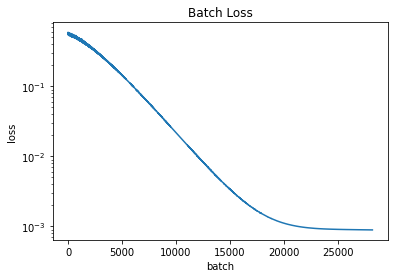

In [25]:
plt.plot(train_batch_loss)
plt.yscale('log')
plt.title('Batch Loss')
plt.xlabel('batch')
plt.ylabel('loss')

Text(0, 0.5, 'loss')

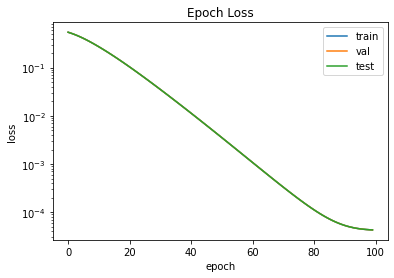

In [26]:
plt.plot(train_epoch_loss, label = 'train')
plt.plot(val_epoch_loss,   label = 'val'  )
plt.plot(test_epoch_loss,  label = 'test' )
plt.legend()
plt.yscale('log')
plt.title('Epoch Loss')
plt.xlabel('epoch')
plt.ylabel('loss')

### Визуалиазция коэффициентов модели

In [27]:
for param in blade_chest_model.named_parameters():
    print(param)
    print('---------------------------')

('blade_emb.weight', Parameter containing:
tensor([[-1.8220, -1.3760,  2.0952],
        [ 2.2197, -1.0776, -2.1348]], device='cuda:0', requires_grad=True))
---------------------------
('blade_emb.bias', Parameter containing:
tensor([0.0096, 0.1205], device='cuda:0', requires_grad=True))
---------------------------
('chest_emb.weight', Parameter containing:
tensor([[-1.7217,  2.1473, -0.2555],
        [ 0.8485, -1.9505,  1.9020]], device='cuda:0', requires_grad=True))
---------------------------
('chest_emb.bias', Parameter containing:
tensor([ 0.0302, -0.0184], device='cuda:0', requires_grad=True))
---------------------------


https://stackoverflow.com/questions/42704283/adding-l1-l2-regularization-in-pytorch

`L1_reg = torch.tensor(0., requires_grad=True)`

`for name, param in model.named_parameters():`

`    if 'weight' in name:`

`        L1_reg = L1_reg + torch.norm(param, 1)`

`total_loss = total_loss + 10e-4 * L1_reg`

In [28]:
for param in blade_chest_model.parameters():
    print(param)
    print('---------------------------')

Parameter containing:
tensor([[-1.8220, -1.3760,  2.0952],
        [ 2.2197, -1.0776, -2.1348]], device='cuda:0', requires_grad=True)
---------------------------
Parameter containing:
tensor([0.0096, 0.1205], device='cuda:0', requires_grad=True)
---------------------------
Parameter containing:
tensor([[-1.7217,  2.1473, -0.2555],
        [ 0.8485, -1.9505,  1.9020]], device='cuda:0', requires_grad=True)
---------------------------
Parameter containing:
tensor([ 0.0302, -0.0184], device='cuda:0', requires_grad=True)
---------------------------


In [29]:
blade_chest_model.blade_emb, blade_chest_model.chest_emb 

(Linear(in_features=3, out_features=2, bias=True),
 Linear(in_features=3, out_features=2, bias=True))

In [30]:
blade_chest_model.blade_emb.weight

Parameter containing:
tensor([[-1.8220, -1.3760,  2.0952],
        [ 2.2197, -1.0776, -2.1348]], device='cuda:0', requires_grad=True)

In [31]:
blade, chest = (
    blade_chest_model.blade_emb.weight.data.detach().cpu().numpy(),
    blade_chest_model.chest_emb.weight.data.detach().cpu().numpy()
)

print(blade)
print(chest)

[[-1.821999  -1.3759925  2.0951815]
 [ 2.2196684 -1.0776422 -2.134807 ]]
[[-1.7216899  2.147337  -0.2554605]
 [ 0.8485159 -1.9505346  1.9020009]]


0 (-1.7216899, 0.8485159, -0.100309014, 1.3711524)
1 (2.147337, -1.9505346, -3.5233295, 0.8728924)
2 (-0.2554605, 1.9020009, 2.350642, -4.036808)


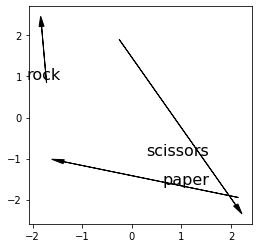

In [32]:
fig, ax = plt.subplots(1,1,figsize=(4,4))

offset = [[0, -0.5],      # rock
          [0.7, 0],      # paper
          [0.0, -0.7],    # scissors
         ]

for i, unit in enumerate(['rock', 'paper', 'scissors']):
    unit_blade = blade[:,i]
    unit_chest = chest[:,i]
    x, y   = unit_chest
    dx, dy = unit_blade - unit_chest
    ox, oy = offset[i]
    
    print(i, (x, y, dx, dy))
    ax.arrow(x,  y, 
             dx, dy, 
             head_width=0.1, head_length=0.25, fc='black', ec='black')
    
    ax.text(x + dx/2 + ox, y + dy/2 + oy, 
            s = unit, 
            size=16, ha='center', va='center', color='black')
    
plt.show()    
#x, y

В статьях Shuo Chen получилась более регулярная картина. <br> 
Вероятно, он использовал регуляризацию или контролировал начальные коэффициенты

<img src="https://www.researchgate.net/profile/Thorsten-Joachims/publication/310825028/figure/fig9/AS:631996137086978@1527691029945/The-visualization-of-the-blade-chest-dist-model-trained-on-a-synthetic.png" alt="Drawing" style="width: 400px;" align="left" >



## Оптимизация модели: Shuo Chen's blade-chest distance model

$M(a,b) = {\| \mathbf{b}_{blade} - \mathbf{a}_{chest} \|}^{2} - {\| \mathbf{a}_{blade} - \mathbf{b}_{chest} \|}^{2} $

In [33]:
class BladeChestDistance(nn.Module):
    def __init__(self, num_units=num_u, num_embeddings=num_emb):
        super(BladeChestDistance, self).__init__()
        self.blade_emb = nn.Linear(num_units, num_embeddings)
        self.chest_emb = nn.Linear(num_units, num_embeddings)

    def forward(self, batch):
        team1, team2 = batch
        team1_blade = self.blade_emb(team1)
        team2_blade = self.blade_emb(team2)
        team1_chest = self.chest_emb(team1)
        team2_chest = self.chest_emb(team2)
        
        blade1_chest2 = team1_blade - team2_chest
        blade2_chest1 = team2_blade - team1_chest

        team1_attack = - batch_dot(blade1_chest2, blade1_chest2)
        team2_attack = - batch_dot(blade2_chest1, blade2_chest1)
        
        logits = team1_attack - team2_attack
        return logits

In [34]:
# Объявляем модель
blade_chest_distance_model = BladeChestDistance( num_units      = num_u, 
                                                 num_embeddings = num_emb
                                               ).cuda()

In [35]:
# Функция потерь
crossentropy = nn.BCEWithLogitsLoss()  

In [36]:
# Оптимизатор
optimizer = torch.optim.Adam(blade_chest_distance_model.parameters(), 
                             lr=1e-4)

In [37]:
# Обучаем модель

train_batch_loss = []

train_epoch_loss = []
test_epoch_loss  = []
val_epoch_loss   = []

for epoch in range(64):
    train_batch_loss = train_batch_loss + run_epoch(blade_chest_distance_model, optimizer = optimizer)
    
    train_prediction = get_prediction(train2_loader, blade_chest_distance_model)    # train2_loader - без shuffle
    val_prediction   = get_prediction(val_loader,    blade_chest_distance_model)
    test_prediction  = get_prediction(test_loader,   blade_chest_distance_model)  
    
    train_epoch_loss.append( log_loss(y_train, train_prediction) )
    val_epoch_loss.append(   log_loss(y_val,   val_prediction)   )
    test_epoch_loss.append(  log_loss(y_test,  test_prediction)  )


282it [00:01, 263.61it/s]
282it [00:01, 258.20it/s]
282it [00:01, 280.96it/s]
282it [00:01, 278.82it/s]
282it [00:01, 280.82it/s]
282it [00:00, 283.81it/s]
282it [00:00, 292.01it/s]
282it [00:00, 304.92it/s]
282it [00:01, 281.60it/s]
282it [00:01, 281.01it/s]
282it [00:01, 280.29it/s]
282it [00:01, 275.25it/s]
282it [00:01, 275.24it/s]
282it [00:00, 285.36it/s]
282it [00:01, 275.51it/s]
282it [00:01, 275.56it/s]
282it [00:01, 275.13it/s]
282it [00:00, 291.57it/s]
282it [00:01, 279.63it/s]
282it [00:00, 282.13it/s]
282it [00:01, 278.47it/s]
282it [00:01, 270.33it/s]
282it [00:01, 277.02it/s]
282it [00:01, 275.92it/s]
282it [00:00, 285.04it/s]
282it [00:01, 275.92it/s]
282it [00:01, 278.12it/s]
282it [00:00, 283.18it/s]
282it [00:00, 284.35it/s]
282it [00:01, 277.13it/s]
282it [00:00, 335.90it/s]
282it [00:01, 273.28it/s]
282it [00:01, 273.14it/s]
282it [00:01, 279.69it/s]
282it [00:01, 281.00it/s]
282it [00:00, 284.43it/s]
282it [00:01, 281.01it/s]
282it [00:01, 276.09it/s]
282it [00:01

In [38]:
val_prediction   = get_prediction(val_loader,    blade_chest_distance_model)
val_prediction

val_loss = log_loss(y_val, val_prediction)
print('Blade-chest model', val_loss)

Blade-chest model 0.0001866991733550094


Text(0, 0.5, 'loss')

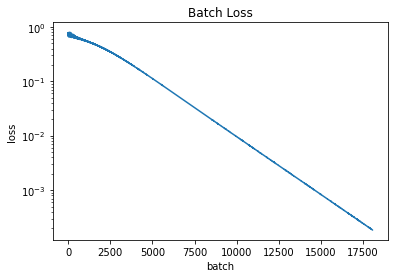

In [39]:
plt.plot(train_batch_loss)
plt.yscale('log')
plt.title('Batch Loss')
plt.xlabel('batch')
plt.ylabel('loss')

Text(0, 0.5, 'loss')

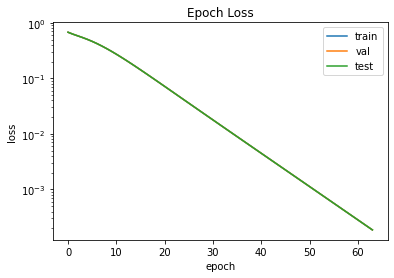

In [40]:
plt.plot(train_epoch_loss, label = 'train')
plt.plot(val_epoch_loss,   label = 'val'  )
plt.plot(test_epoch_loss,  label = 'test' )
plt.legend()
plt.yscale('log')
plt.title('Epoch Loss')
plt.xlabel('epoch')
plt.ylabel('loss')

In [41]:
blade_chest_distance_model.blade_emb, blade_chest_distance_model.chest_emb 

(Linear(in_features=3, out_features=2, bias=True),
 Linear(in_features=3, out_features=2, bias=True))

In [42]:
blade, chest = (
    blade_chest_distance_model.blade_emb.weight.data.detach().cpu().numpy(),
    blade_chest_distance_model.chest_emb.weight.data.detach().cpu().numpy()
)

print(blade)
print(chest)

[[-1.6018585   1.568798   -0.24142067]
 [-1.337373    1.4071794  -1.5383244 ]]
[[ 0.85449123  0.9645394  -1.1171577 ]
 [ 1.5154103  -0.10170816 -0.7263972 ]]


0 (0.85449123, 1.5154103, -2.4563498, -2.8527832)
1 (0.9645394, -0.10170816, 0.60425854, 1.5088875)
2 (-1.1171577, -0.7263972, 0.875737, -0.81192714)


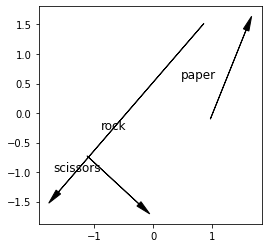

In [43]:
fig, ax = plt.subplots(1,1,figsize=(4,4))

offset = [[-0.3, -0.3],  # rock
          [-0.5, 0],      # paper
          [-0.6, 0.2],      # scissors
         ]

for i, unit in enumerate(['rock', 'paper', 'scissors']):
    unit_blade = blade[:,i]
    unit_chest = chest[:,i]
    x, y   = unit_chest
    dx, dy = unit_blade - unit_chest
    ox, oy = offset[i]
    
    print(i, (x, y, dx, dy))
    ax.arrow(x,  y, 
             dx, dy, 
             head_width=0.1, head_length=0.25, fc='black', ec='black')
    
    ax.text(x + dx/2 + ox, y + dy/2 + oy, 
            s = unit, 
            size=12, ha='center', va='center', color='black')
    
plt.show()    
#x, y

Ожидал, что получится, как в статье

<img src="https://www.researchgate.net/profile/Thorsten-Joachims/publication/310825028/figure/fig9/AS:631996137086978@1527691029945/The-visualization-of-the-blade-chest-dist-model-trained-on-a-synthetic.png" alt="Drawing" style="width: 400px;" align="left" >



# LightGBM

## Как НЕ получить результат

Из-за особенностей данных, разбиение по любому отдельному признаку не приводит к улучшению качества прогноза.

In [65]:
data_train_lgb = np.concatenate([team1_train, team2_train], axis=1)
data_val_lgb   = np.concatenate([team1_val,   team2_val],   axis=1)
data_test_lgb  = np.concatenate([team1_test,  team2_test],  axis=1)

In [66]:
data_train_lgb[:4]

array([[1, 0, 0, 0, 1, 0],
       [0, 0, 1, 0, 1, 0],
       [0, 0, 1, 0, 1, 0],
       [0, 0, 1, 0, 1, 0]], dtype=uint8)

In [67]:
lgb = LGBMClassifier(
    n_jobs=10,
    max_depth=3,
    subsample=1,
    n_estimators=100,
    learning_rate=0.1,
    colsample_bytree=1,
    objective='binary',
    boosting_type='gbdt',
    min_data=1,
    min_hess=0
)

start = time.time()
lgb.fit(encoded_pairs_train, y_train.ravel())
lgb_elapse = time.time() - start
print('elapse:, ', lgb_elapse)

[LightGBM] [Warning] Unknown parameter: min_hess
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=1. Current value: min_data_in_leaf=1
elapse:,  0.08458232879638672


In [68]:
y_pred_val = lgb.predict_proba(data_val_lgb)[:, 1]
lgb_auc_val = roc_auc_score(y_val, y_pred_val)
print('auc score val: ', lgb_auc_val)


y_pred_test = lgb.predict_proba(data_test_lgb)[:, 1]
lgb_auc_test = roc_auc_score(y_test, y_pred_test)
print('auc score test:', lgb_auc_test)

auc score val:  0.6666666666666667
auc score test: 0.6666666666666667


## Как получить результат

Из-за особенностей данных, разбиение по любому отдельному признаку не приводит к улучшению качества прогноза.

А разбиение сразу по паре признаков позволяет получить достоверные предсказания.

Поэтому из пар признаков создаём комбинированные признаки-пары. Их и будем использовать

In [69]:
def get_pairs_arr(data_lgb):
    pairs_arr = []
    for arr in data_lgb:
        res = int("".join(str(x) for x in list(arr)), 2)
        pairs_arr.extend([res])
        
    return pairs_arr

In [70]:
def encode_pairs(data_lgb):
    pairs_arr = get_pairs_arr(data_lgb)     # 2^N encoding of pair
    pairs = sorted(list(set(pairs_arr)))
    n_pairs = len(pairs)
    pair_dict = dict( zip( pairs, list( range(n_pairs) ) ) )
    
    result = []
    for pair in pairs_arr:
        extension = np.zeros(n_pairs)
        extension[pair_dict[pair]] = 1
        result.extend([extension])
    
    return result

In [71]:
encoded_pairs_train = encode_pairs(data_train_lgb)
encoded_pairs_val   = encode_pairs(data_val_lgb)
encoded_pairs_test  = encode_pairs(data_test_lgb)

In [72]:
encoded_pairs_train[:4]

[array([0., 0., 0., 0., 0., 1.]),
 array([1., 0., 0., 0., 0., 0.]),
 array([1., 0., 0., 0., 0., 0.]),
 array([1., 0., 0., 0., 0., 0.])]

In [73]:
lgb = LGBMClassifier(
    n_jobs=10,
    max_depth=3,
    subsample=1,
    n_estimators=100,
    learning_rate=0.1,
    colsample_bytree=1,
    objective='binary',
    boosting_type='gbdt',
    min_data=1,
    min_hess=0
)

start = time.time()
lgb.fit(encoded_pairs_train, y_train.ravel())
lgb_elapse = time.time() - start
print('elapse:, ', lgb_elapse)

[LightGBM] [Warning] Unknown parameter: min_hess
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=1. Current value: min_data_in_leaf=1
elapse:,  0.06427168846130371


In [74]:
y_pred_val = lgb.predict_proba(encoded_pairs_val)[:, 1]
lgb_auc_val = roc_auc_score(y_val, y_pred_val)
print('auc score val: ', lgb_auc_val)


y_pred_test = lgb.predict_proba(encoded_pairs_test)[:, 1]
lgb_auc_test = roc_auc_score(y_test, y_pred_test)
print('auc score test:', lgb_auc_test)

auc score val:  1.0
auc score test: 1.0
